## Download the Dataset

In [1]:
!wget https://storage.googleapis.com/tensorflow-1-public/course3/sarcasm.json

--2022-10-12 20:44:03--  https://storage.googleapis.com/tensorflow-1-public/course3/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.128, 74.125.68.128, 142.250.4.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘sarcasm.json.1’

sarcasm.json.1      100%[===================>]   5.38M  --.-KB/s    in 0.03s   

2022-10-12 20:44:03 (186 MB/s) - ‘sarcasm.json.1’ saved [5643545/5643545]



In [2]:
# Parse dataset
import json

with open("./sarcasm.json", 'r') as f:
    datastore = json.load(f)

sentences = []
labels = []

for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

## Split the Dataset

In [3]:
training_size = 20000

# Split the sentences
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]

# Split the labels
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

## Data preprocessing

In [4]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = 10000
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

# Initialize the Tokenizer class
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

# Generate the word index dictionary
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

In [5]:
# Generate and pad the training sequences
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Generate and pad the testing sequences
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Convert the labels lists into numpy arrays
training_labels = np.array(training_labels)
testing_labels = np.array(testing_labels)

## Build, Compile and Train the Model

### 1. LSTM

In [6]:
import tensorflow as tf

# Parameters
embedding_dim = 16
lstm_dim = 32
dense_dim = 24

# Model Definition with LSTM
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_dim)),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
model_lstm.compile(loss='binary_crossentropy',
                   optimizer='adam',
                   metrics=['accuracy'])

# Print the model summary
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 16)           160000    
                                                                 
 bidirectional (Bidirectiona  (None, 64)               12544     
 l)                                                              
                                                                 
 dense (Dense)               (None, 24)                1560      
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 174,129
Trainable params: 174,129
Non-trainable params: 0
_________________________________________________________________


In [7]:
# Train the model
history_lstm = model_lstm.fit(training_padded,
                              training_labels,
                              epochs=10,
                              validation_data=(testing_padded, testing_labels))

Epoch 1/10
625/625 [==============================] - 19s 24ms/step - loss: 0.4134 - accuracy: 0.7970 - val_loss: 0.3270 - val_accuracy: 0.8562
Epoch 2/10
625/625 [==============================] - 12s 20ms/step - loss: 0.2244 - accuracy: 0.9090 - val_loss: 0.3443 - val_accuracy: 0.8574
Epoch 3/10
625/625 [==============================] - 9s 15ms/step - loss: 0.1537 - accuracy: 0.9430 - val_loss: 0.3910 - val_accuracy: 0.8478
Epoch 4/10
625/625 [==============================] - 8s 13ms/step - loss: 0.1072 - accuracy: 0.9611 - val_loss: 0.4405 - val_accuracy: 0.8472
Epoch 5/10
625/625 [==============================] - 9s 14ms/step - loss: 0.0724 - accuracy: 0.9764 - val_loss: 0.5167 - val_accuracy: 0.8427
Epoch 6/10
625/625 [==============================] - 8s 13ms/step - loss: 0.0499 - accuracy: 0.9833 - val_loss: 0.6292 - val_accuracy: 0.8347
Epoch 7/10
625/625 [==============================] - 8s 13ms/step - loss: 0.0358 - accuracy: 0.9883 - val_loss: 0.7332 - val_accuracy: 0.83

In [8]:
import matplotlib.pyplot as plt

# Plot Utility
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

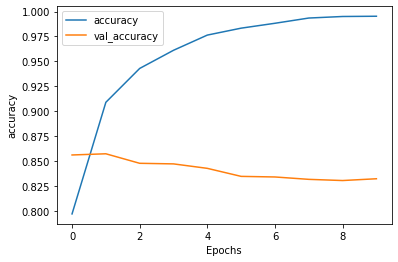

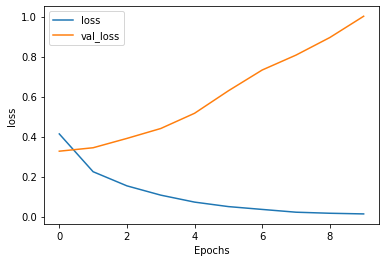

In [9]:
# Plot the accuracy and loss history
plot_graphs(history_lstm, 'accuracy')
plot_graphs(history_lstm, 'loss')

### Conv1D

In [10]:
import tensorflow as tf

# Parameters
embedding_dim = 16
filters = 128
kernel_size = 5
dense_dim = 6

# Model Definition with Conv1D
model_conv = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(filters, kernel_size, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
model_conv.compile(loss='binary_crossentropy',
                   optimizer='adam',
                   metrics=['accuracy'])

# Print the model summary
model_conv.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 120, 16)           160000    
                                                                 
 conv1d (Conv1D)             (None, 116, 128)          10368     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_2 (Dense)             (None, 6)                 774       
                                                                 
 dense_3 (Dense)             (None, 1)                 7         
                                                                 
Total params: 171,149
Trainable params: 171,149
Non-trainable params: 0
________________________________________________

In [11]:
# Train the model
history_conv = model_conv.fit(training_padded,
                              training_labels,
                              epochs=10,
                              validation_data=(testing_padded, testing_labels))

Epoch 1/10
625/625 [==============================] - 5s 5ms/step - loss: 0.5303 - accuracy: 0.7502 - val_loss: 0.4537 - val_accuracy: 0.8250
Epoch 2/10
625/625 [==============================] - 3s 5ms/step - loss: 0.3491 - accuracy: 0.8849 - val_loss: 0.4175 - val_accuracy: 0.8356
Epoch 3/10
625/625 [==============================] - 3s 5ms/step - loss: 0.2370 - accuracy: 0.9320 - val_loss: 0.4274 - val_accuracy: 0.8351
Epoch 4/10
625/625 [==============================] - 3s 5ms/step - loss: 0.1695 - accuracy: 0.9556 - val_loss: 0.5410 - val_accuracy: 0.8350
Epoch 5/10
625/625 [==============================] - 3s 4ms/step - loss: 0.1278 - accuracy: 0.9689 - val_loss: 0.5819 - val_accuracy: 0.8347
Epoch 6/10
625/625 [==============================] - 3s 5ms/step - loss: 0.1072 - accuracy: 0.9753 - val_loss: 0.6471 - val_accuracy: 0.8351
Epoch 7/10
625/625 [==============================] - 3s 4ms/step - loss: 0.0975 - accuracy: 0.9766 - val_loss: 0.6399 - val_accuracy: 0.8323
Epoch 

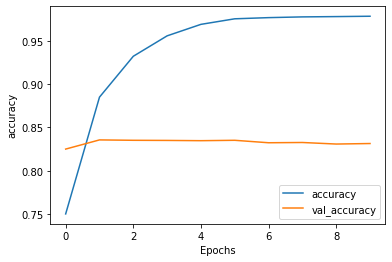

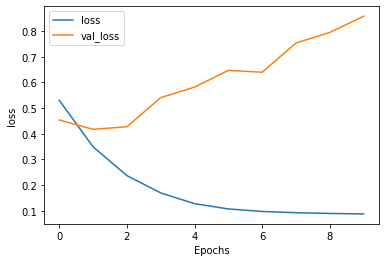

In [12]:
# Plot the accuracy and loss history
plot_graphs(history_conv, 'accuracy')
plot_graphs(history_conv, 'loss')